# 1. Get Data and preprocess it 

In [2]:
import os,torch, torchvision, pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from pathlib import Path


In [3]:
import os

directory = "../Data"
def print_directory_file_counts(directory):
    """
    Prints the name of each directory and the number of files it contains.

    Args:
        directory (str): Path to the root directory.
    """
    for root, dirs, files in os.walk(directory):
        # Use the folder name instead of the full path for simplicity
        dir_name = os.path.basename(root) or root  # Handles the root folder name
        file_count = len(files)
        print(f"Directory: {dir_name}, Files: {file_count}")
print_directory_file_counts(directory)




Directory: Data, Files: 0
Directory: test, Files: 0
Directory: Cancer, Files: 224
Directory: normal, Files: 54
Directory: train, Files: 0
Directory: Cancer, Files: 418
Directory: normal, Files: 148
Directory: valid, Files: 0
Directory: Cancer, Files: 35
Directory: normal, Files: 13


## 1.1 Creating Dataset class for Chest x ray data

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [5]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform):
        """
        Args:
            root_dir (str): Path to the directory containing class folders.
            transform (callable): Transformations to apply to the images.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Folder names as class labels
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map folder name to class index
        self.image_paths = []
        self.labels = []
        for cls in self.classes:
            cls_path = self.root_dir /  Path(cls)
            for img_file in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_file))
                self.labels.append(self.class_to_idx[cls])
    

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
test_dataset = ChestXrayDataset(root_dir="../Data/test", transform=transforms.ToTensor())
train_dataset = ChestXrayDataset(root_dir="../Data/train", transform=transforms.ToTensor())
valid_dataset = ChestXrayDataset(root_dir="../Data/valid", transform=transforms.ToTensor())


## 1.1 creating Dataloaders 

In [7]:
from torchvision.models import DenseNet121_Weights

# Specify the weights to use from the DenseNet121 model
weights = DenseNet121_Weights.DEFAULT
# Get the transforms associated with the weights
Densenet_transforms = weights.transforms()

test_dataset = ChestXrayDataset(root_dir="../Data/test", transform=Densenet_transforms)
train_dataset = ChestXrayDataset(root_dir="../Data/train", transform=Densenet_transforms)
valid_dataset = ChestXrayDataset(root_dir="../Data/valid", transform=Densenet_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)



## 1.2 Visualizing some examples 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].


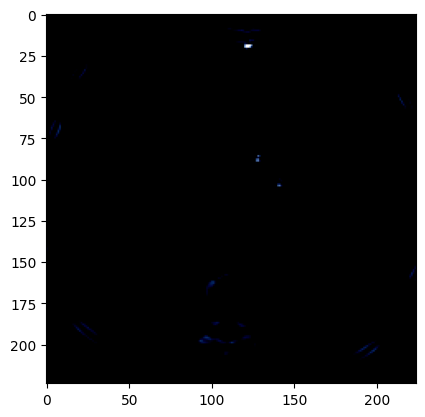

In [8]:
import matplotlib.pyplot as plt
img = next(iter(train_dataloader))[0]
plt.imshow(img[0].permute(1, 2, 0))

In [9]:
%%writefile ../src/Chest_Cancer_Classification/utils/data_setup.py
"""
    Setsup the data for the model
"""
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import os
from torchvision.models import DenseNet121_Weights
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform):
        """
        Args:
            root_dir (str): Path to the directory containing class folders.
            transform (callable): Transformations to apply to the images.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Folder names as class labels
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map folder name to class index
        self.image_paths = []
        self.labels = []
        for cls in self.classes:
            cls_path = self.root_dir / Path(cls)
            for img_file in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_file))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def get_data_loaders(root_dir, batch_size=32):
    # Specify the weights to use from the DenseNet121 model
    weights = DenseNet121_Weights.DEFAULT
    # Get the transforms associated with the weights
    densenet_transforms = weights.transforms()

    # Initialize datasets
    train_dataset = ChestXrayDataset(root_dir=os.path.join(root_dir, "train"), transform=densenet_transforms)
    test_dataset = ChestXrayDataset(root_dir=os.path.join(root_dir, "test"), transform=densenet_transforms)
    valid_dataset = ChestXrayDataset(root_dir=os.path.join(root_dir, "valid"), transform=densenet_transforms)

    # Initialize data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader, valid_dataloader, train_dataset.classes

Overwriting ../src/Chest_Cancer_Classification/utils/data_setup.py


# 2. Creating a Model

## 2.1 Building a Feature extracting model using pytorch.lightning

In [10]:
from torchvision.models import densenet121
dense_net = densenet121(weights=DenseNet121_Weights.DEFAULT)
dense_net 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import pytorch_lightning as pl
from torchvision.models import densenet121, DenseNet121_Weights

class ChestXrayModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        in_features = self.model.classifier.in_features
        for params in self.model.parameters():
            params.requires_grad = False
        for params in list(self.model.parameters())[-5:]:
            params.requires_grad = True
        self.model.classifier = torch.nn.Linear(in_features, 1)  # Single output neuron for binary classification

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)  # Squeeze to match the shape [batch_size]
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        return [optimizer], [scheduler]


In [13]:
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping




early_stopping_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")
model_checkpoint = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min",dirpath="/logs", filename="best_checkpoint")
mlf_logger = MLFlowLogger(experiment_name="Chest_Cancer_Classification",tracking_uri="http://127.0.0.1:5000")

#model = ChestXrayModel.load_from_checkpoint(checkpoint_path="/logs/911995652359186367/bb09eba95d0e4a609d38b93f45f7bca3/checkpoints/epoch=9-step=180.ckpt")
model = ChestXrayModel.load_from_checkpoint(checkpoint_path="/logs/911995652359186367/77eef2425a1f41b19b50d374b94bee43/checkpoints/epoch=14-step=270.ckpt")

trainer = pl.Trainer(max_epochs=15, logger=mlf_logger,default_root_dir="/logs")

#trainer.fit(model, train_dataloader, valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
trainer.test(model, dataloaders=test_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\siddh\OneDrive\Desktop\PyTorch_Projects\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9928057789802551     │
│         test_loss         │    0.03601770102977753    │
└───────────────────────────┴───────────────────────────┘

🏃 View run nebulous-shrike-909 at: http://127.0.0.1:5000/#/experiments/911995652359186367/runs/8b97816f79b84e74aeb93dfe1b00788d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/911995652359186367


[{'test_loss': 0.03601770102977753, 'test_acc': 0.9928057789802551}]

In [16]:

torch.save(model.state_dict(), "Best_model.pth")
